In [239]:
using Plots

In [240]:
using Distributions

In [241]:
function simulate_realization(M, s1, s2)
    # Number of days
    days = 60
    
    # State
    # number of worn machines
    W = zeros(Int, days)
    # number of broken machines
    B = zeros(Int, days)
    
    # probability of new -> worn
    p12 = (1/60) + (1/200 - 1/60) * sqrt(1 - ((10 - s1) / 10)^2)
    # probability of worn -> broken
    p23 = (1/30) + (1/100 - 1/30) * sqrt(1 - ((10 - s2) / 10)^2)
    
    # Simulate
    for i in 1:(days-1)
        B12 = rand(Binomial(M-W[i]-B[i], p12))
        B23 = rand(Binomial(W[i], p23))
        
        W[i+1] = W[i] + B12 - B23
        B[i+1] = B[i] +     + B23 - B[i]
    end
    
    N = M * ones(days) - W - B
    
    N, W, B
end

function total_gain(M, B)
    total = 0.0
    for day in 1:60
        total += (1 * (M - B[day]) - 90 * B[day] - s1 - s2)
    end
    return total
end

function simulate(M, s1, s2)
    gain = 0.0
    
    realizations = 10_000
    for _ in 1:realizations
        N, W, B = simulate_realization(M, s1, s2)
        gain += total_gain(M, B)
    end
    
    return gain / realizations
end

# Total number of machines
M = 2_000

# Parameters
# money spent daily for maintainance of worn machines
s1 = 4
# money spent daily for maintainance of broken machines
s2 = 6
@time simulate(M, s1, s2)

  0.598371 seconds (2.59 M allocations: 76.195 MiB, 8.85% gc time)


99931.1324

---

In [243]:
X = []
y = []
@time for j=2:2:10, k=2:2:10
    gain = simulate(M, j, k)
    push!(X, [j, k])
    push!(y, [gain])
    println("($j, $k) = $(gain)")
end

(2, 2) = 83625.5977
(2, 4) = 90265.5583
(2, 6) = 94665.6904
(2, 8) = 97203.3073
(2, 10) = 98034.6651
(4, 2) = 91309.8197
(4, 4) = 96498.2666
(4, 6) = 99923.0607
(4, 8) = 101938.3922
(4, 10) = 102574.7097
(6, 2) = 96034.3304
(6, 4) = 100351.8254
(6, 6) = 103176.5109
(6, 8) = 104843.8311
(6, 10) = 105403.8087
(8, 2) = 98675.7692
(8, 4) = 102495.8673
(8, 6) = 104996.52
(8, 8) = 106475.9161
(8, 10) = 106969.9096
(10, 2) = 99545.0103
(10, 4) = 103204.3114
(10, 6) = 105593.6438
(10, 8) = 107024.0273
(10, 10) = 107485.5975
  6.804492 seconds (61.73 M allocations: 1.702 GiB, 7.00% gc time)


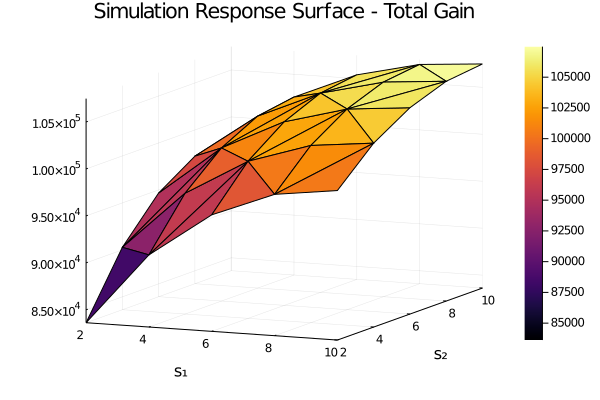

In [244]:
surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface - Total Gain", xlabel="s₁", ylabel="s₂", margin=5Plots.mm)

---

In [245]:
using Random

using LinearAlgebra

using Printf

In [246]:
sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x) * (1 - sigma(x))

sigma_prime (generic function with 1 method)

In [247]:
y_mean = mean(y)[1]
y_std = std(y)[1]

function z_transform(yi)
    (yi - y_mean) / y_std
end

function inv_z_transform(yi)
    (yi * y_std) + y_mean
end

inv_z_transform (generic function with 1 method)

In [248]:
function nn(x, W1, b1, W2, b2)
    z1 = W1 * x + b1
    a1 = sigma.(z1)
    z2 = W2 * a1 + b2
    a2 = z2
    return a2[1]
end

function compute_loss(X, y, W1, b1, W2, b2)
    loss = 0.0
    for (x, y_true) in zip(X, y)
        y_true = z_transform.(y_true)
        y_hat = nn(x, W1, b1, W2, b2)

        loss += (y_hat[1] - y_true[1])^2
    end
    loss /= (2 * size(X, 1))
    return loss
end

compute_loss (generic function with 1 method)

In [249]:
Random.seed!(1234);

mu = 5e-3

INPUT_SIZE = 2
HIDDEN_LAYER_SIZE = 100
W1 = randn(HIDDEN_LAYER_SIZE, INPUT_SIZE)
b1 = randn(HIDDEN_LAYER_SIZE, 1)

OUTPUT_LAYER_SIZE = 1
W2 = randn(OUTPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE)
b2 = randn(OUTPUT_LAYER_SIZE, 1)

for it in 1:10_000
    for (x, y_true) in zip(X, y)
        y_true = z_transform.(y_true)
        
        # Forward step to evaluate intermediate results
        z1 = W1 * x + b1
        a1 = sigma.(z1)
        z2 = W2 * a1 + b2
        a2 = z2

        # Backward step to evaluate parameter derivatives w.r.t. loss
        # d(loss)/d(z2) is `dz2`
        dz2 = a2 - y_true
        dW2 = dz2 * a1'
        db2 = dz2

        dz1 = (W2' * dz2) .* sigma_prime.(z1)
        dW1 = dz1 * x'
        db1 = dz1

        # Steepest descent to find optimal parameters
        W2 -= mu * dW2
        b2 -= mu * db2

        W1 -= mu * dW1
        b1 -= mu * db1
    end
    
    mu *= 0.9995
    
    if it % 200 == 0
        println("[$it]: $(@sprintf("%.3E", compute_loss(X, y, W1, b1, W2, b2))), μ=$(@sprintf("%.3E", mu))")
    end
end

[200]: 1.108E-03, μ=4.524E-03
[400]: 5.862E-04, μ=4.093E-03
[600]: 4.422E-04, μ=3.704E-03
[800]: 3.736E-04, μ=3.351E-03
[1000]: 3.318E-04, μ=3.032E-03
[1200]: 3.030E-04, μ=2.744E-03
[1400]: 2.818E-04, μ=2.482E-03
[1600]: 2.656E-04, μ=2.246E-03
[1800]: 2.529E-04, μ=2.032E-03
[2000]: 2.427E-04, μ=1.839E-03
[2200]: 2.345E-04, μ=1.664E-03
[2400]: 2.278E-04, μ=1.506E-03
[2600]: 2.222E-04, μ=1.362E-03
[2800]: 2.175E-04, μ=1.233E-03
[3000]: 2.136E-04, μ=1.115E-03
[3200]: 2.102E-04, μ=1.009E-03
[3400]: 2.073E-04, μ=9.130E-04
[3600]: 2.048E-04, μ=8.261E-04
[3800]: 2.027E-04, μ=7.475E-04
[4000]: 2.008E-04, μ=6.763E-04
[4200]: 1.992E-04, μ=6.120E-04
[4400]: 1.978E-04, μ=5.537E-04
[4600]: 1.965E-04, μ=5.010E-04
[4800]: 1.954E-04, μ=4.533E-04
[5000]: 1.945E-04, μ=4.102E-04
[5200]: 1.936E-04, μ=3.711E-04
[5400]: 1.928E-04, μ=3.358E-04
[5600]: 1.922E-04, μ=3.038E-04
[5800]: 1.915E-04, μ=2.749E-04
[6000]: 1.910E-04, μ=2.487E-04
[6200]: 1.905E-04, μ=2.251E-04
[6400]: 1.901E-04, μ=2.036E-04
[6600]: 1.89

---

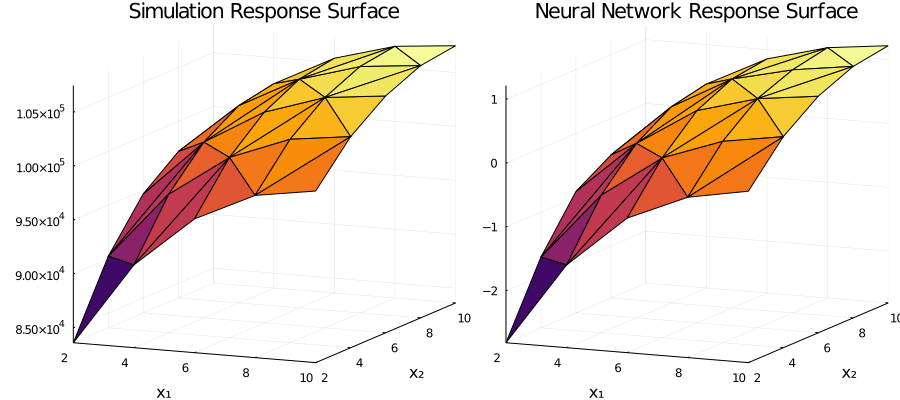

In [250]:
plot(
    surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y], title="Simulation Response Surface", legend=false),
    surface([x[1] for x in X], [x[2] for x in X], [nn(x, W1, b1, W2, b2) for (x,y) in zip(X,y)], title="Neural Network Response Surface", legend=false),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂"
)

---

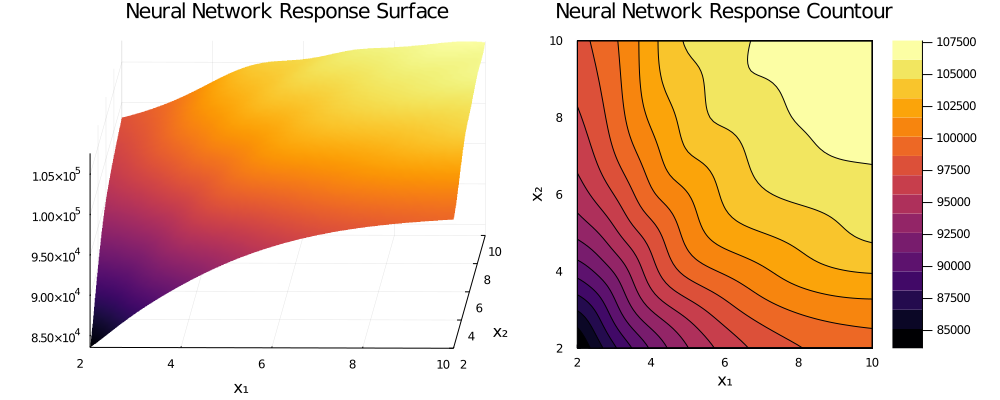

In [251]:
function plot_surface()
    plot(
        st=:surface,
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        camera=(5,45),
        legend=false,
        title="Neural Network Response Surface"
    )
end

function plot_contour()
    contourf(
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        title="Neural Network Response Countour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

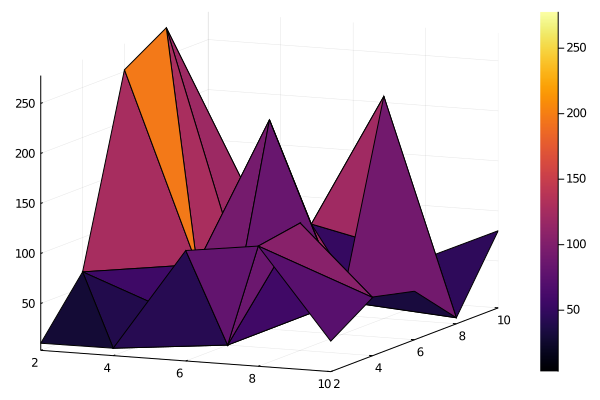

In [252]:
surface([x[1] for x in X], [x[2] for x in X], [abs((yi .- inv_z_transform.(nn(xi, W1, b1, W2, b2)))[1]) for (xi,yi) in zip(X,y)])

In [253]:
for x in [[0.2, 0.5], [0.3, 0.9], [0.1, 0.9]]
    gain_nn = (mean(y) + std(y) * nn(x, W1, b1, W2, b2))[1]
    gain_simulation = simulate(M, x[1], x[2])
    println("Gain NN: $(@sprintf("%d", gain_nn)), Gain Simulation: $(@sprintf("%d", gain_simulation))")
end

Gain NN: 86134, Gain Simulation: 58367
Gain NN: 82809, Gain Simulation: 63849
Gain NN: 83797, Gain Simulation: 59990


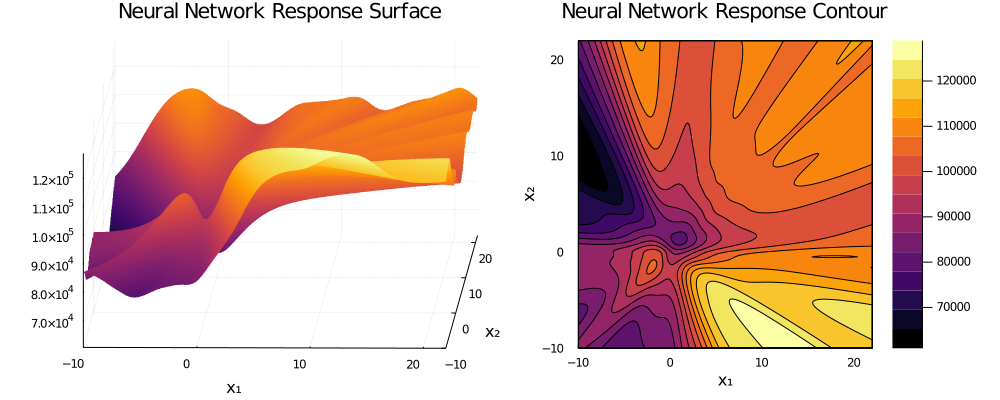

In [254]:
axis_range = -10:0.1:22
function plot_surface()
    plot(
        st=:surface,
        axis_range,
        axis_range,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        camera=(5,45),
        title="Neural Network Response Surface",
        legend=false
    )
end

function plot_contour()
    contourf(
        axis_range,
        axis_range,
        (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
        title="Neural Network Response Contour"
    )
end
plot(plot_surface(), plot_contour(), size=(1000, 400), xlabel="x₁", ylabel="x₂", margin=5Plots.mm)

---

In [256]:
function maximize_gain(;verbose = false)
    m = 1
    m_max = 1000
    
    x = [rand(2:2:10), rand(2:2:10)]
    
    mu = 5e-2
    
    C = 0.1
    
    trajectory = []
    
    
    while m < m_max
        h = rand([1, -1], size(x, 1))
        c = C / m^0.2
        
        nn_pred = inv_z_transform(nn(x, W1, b1, W2, b2))
        if verbose
            println("x=$(round.(x, digits=2)), nn=$(round(nn_pred, digits=1)), c=$(round(c, digits=3))")
        end
            
        if m % 1 == 0
            push!(trajectory, x)
        end
        
        finite_diff = inv_z_transform(nn(x + c*h, W1, b1, W2, b2)) - inv_z_transform(nn(x - c*h, W1, b1, W2, b2))
        dx = [finite_diff / 2*c*h[i] for i in 1:size(x, 1)]

        x_new = x + mu * dx
        
        if (norm(x - x_new)) / norm(x_new) < 1e-4
            verbose && println("Hit termination condition at m=$m, x=$(round.(x, digits=2))")
            break
        end
        
        x = x_new
        
        m += 1
    end
    
    if m == m_max
        verbose && println("Maximum number of iterations reached, m=$m")
    end
    
    return trajectory
end
maximize_gain(verbose = true)
nothing

x=[2.0, 8.0], nn=96925.5, c=0.1
x=[3.24, 9.24], nn=100361.7, c=0.087
x=[4.23, 8.26], nn=102546.8, c=0.08
x=[4.57, 7.91], nn=102908.4, c=0.076
x=[5.28, 8.62], nn=104376.8, c=0.072
x=[5.61, 8.29], nn=104811.1, c=0.07
x=[6.02, 8.71], nn=105434.6, c=0.068
x=[6.33, 9.02], nn=105825.6, c=0.066
x=[6.58, 9.27], nn=106097.7, c=0.064
x=[6.79, 9.48], nn=106300.3, c=0.063
x=[6.88, 9.4], nn=106317.1, c=0.062
x=[6.88, 9.39], nn=106317.1, c=0.061
x=[7.04, 9.56], nn=106454.8, c=0.06
x=[7.19, 9.7], nn=106569.7, c=0.059
x=[7.18, 9.71], nn=106570.3, c=0.058
x=[7.17, 9.72], nn=106570.4, c=0.057
x=[7.17, 9.72], nn=106570.4, c=0.057
x=[7.29, 9.84], nn=106662.0, c=0.056
x=[7.41, 9.96], nn=106742.5, c=0.055
x=[7.4, 9.96], nn=106742.7, c=0.055
x=[7.4, 9.96], nn=106742.7, c=0.054
x=[7.4, 9.96], nn=106742.7, c=0.054
Hit termination condition at m=22, x=[7.4, 9.96]


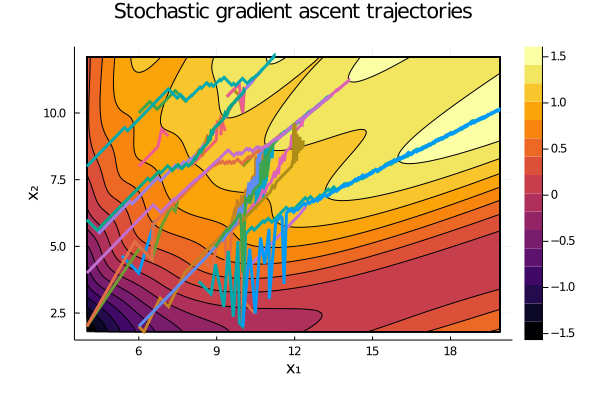

In [257]:
trajectories = [maximize_gain(; verbose=false) for i in 1:25];

min_x = minimum([minimum([p[1] for p in trj]) for trj in trajectories])
max_x = maximum([maximum([p[1] for p in trj]) for trj in trajectories])
min_y = minimum([minimum([p[2] for p in trj]) for trj in trajectories])
max_y = maximum([maximum([p[2] for p in trj]) for trj in trajectories])
nothing

p = contourf(
    min_x:0.1:max_x,
    min_y:0.1:max_y,
    (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
    title="Stochastic gradient ascent trajectories",
    xlabel="x₁", ylabel="x₂", margin=5Plots.mm
)
for (i, trj) in enumerate(trajectories)  
    plot!(st=:line, [p[1] for p in trj], [p[2] for p in trj], legend=false, color=i, lw=3)
end
p

---

In [236]:
test = [@time simulate(M, x1, x2) for x1=2:2:20, x2=2:2:20]

  0.371740 seconds (2.46 M allocations: 69.507 MiB, 8.38% gc time)
  0.472878 seconds (2.47 M allocations: 69.705 MiB, 5.21% gc time)
  0.336587 seconds (2.47 M allocations: 69.728 MiB, 9.00% gc time)
  0.502988 seconds (2.47 M allocations: 69.732 MiB, 3.25% gc time)
  0.273637 seconds (2.47 M allocations: 69.732 MiB, 9.34% gc time)
  0.296493 seconds (2.47 M allocations: 69.731 MiB, 4.27% gc time)
  0.299459 seconds (2.47 M allocations: 69.728 MiB, 8.94% gc time)
  0.314750 seconds (2.47 M allocations: 69.703 MiB, 5.04% gc time)
  0.335231 seconds (2.45 M allocations: 69.502 MiB, 3.77% gc time)
  0.349034 seconds (2.23 M allocations: 66.069 MiB, 8.01% gc time)
  0.288733 seconds (2.47 M allocations: 69.691 MiB, 6.31% gc time)
  0.335067 seconds (2.47 M allocations: 69.728 MiB, 8.97% gc time)
  1.009518 seconds (2.47 M allocations: 69.732 MiB, 5.22% gc time)
  1.138819 seconds (2.47 M allocations: 69.733 MiB, 6.66% gc time)
  0.294411 seconds (2.47 M allocations: 69.732 MiB, 4.24% gc t

10×10 Array{Float64,2}:
 83632.6  90271.3        94687.4        …   90299.8        83605.2  68495.4
 91280.2  96493.6        99932.2            96479.4        91311.8  79567.6
 96001.1      1.00345e5      1.03177e5          1.00324e5  96030.2  86357.6
 98670.3      1.025e5        1.05012e5     102489.0        98673.4  90120.9
 99539.5      1.03204e5      1.05624e5          1.0317e5   99538.4  91395.9
 98666.1      1.02494e5      1.05005e5  …       1.02492e5  98678.0  90135.8
 96029.4      1.00317e5      1.03191e5          1.00312e5  96025.2  86335.2
 91307.7  96497.7        99950.1            96503.1        91290.5  79563.7
 83592.3  90275.1        94663.2            90287.0        83610.2  68456.7
 63528.2  74151.8        81055.9            74173.4        63564.6  39090.7

  0.172218 seconds (235.74 k allocations: 14.047 MiB, 7.76% gc time)


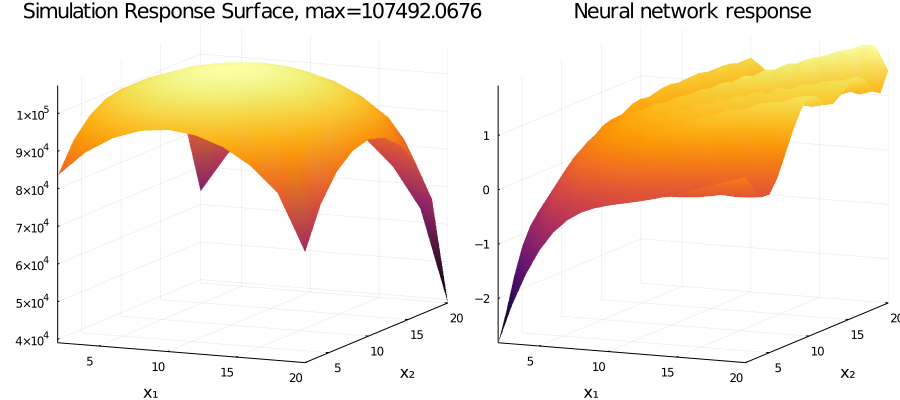

In [258]:
@time plot(
    surface(
        2:2:20, 2:2:20,
        test,
        title="Simulation Response Surface, max=$(maximum(test))",
        legend=false
    ),
    surface(
            2:1:20,
            2:1:20,
            (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
            legend=false,
            title="Neural network response"
    ),
    size=(900, 400),
    xlabel="x₁", ylabel="x₂"
)

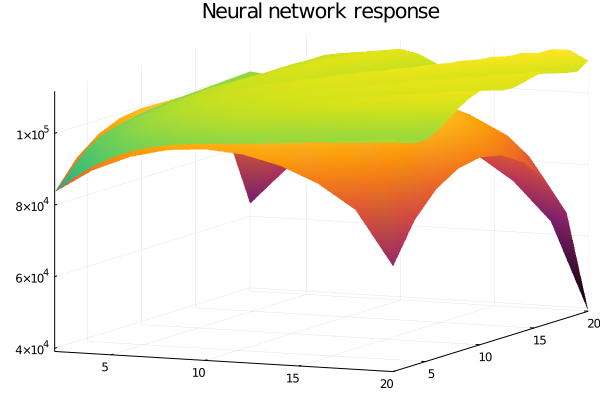

In [259]:
    surface(
        2:2:20, 2:2:20,
        test,
        title="Simulation Response Surface, max=$(maximum(test))",
        legend=false
    )
    surface!(
            2:1:20,
            2:1:20,
            (x1, x2) -> inv_z_transform(nn([x1, x2], W1, b1, W2, b2)),
            legend=false,
            c=:viridis,
            title="Neural network response"
    )
